## E-tivity 2: Neural Networks

In this E-tivity, we will be moving away from *regression* and get into *classification* with a simple artificial neural network (ANN) architecture. First, we will manually implement a *Perceptron* (a simple ANN with no hidden layer) to develop some familiarity with the various components of an ANN. Afterwards, we will use the Scikit-learn Python module (*sklearn*) to implement a slightly more complex ANN with less effort.

Note that in the first part of the E-tivity (the manual perceptron implementation), we won't bother with splitting the source data into training and testing to keep things simple. This is generally a *very bad idea* in machine learning, as you always want to evaluate a model's accuracy on unseen data. Unseen data is data that has not been used in the training nor preprocessing steps and is to ensure that your model isn't overfitting your training data. In the second part, we will take advantage of *sklearn* to do that.

Finally, we will briefly touch upon the concept of *feature engineering*, which is an important part of the machine learning process.


Please skim through the whole notebook before getting started, as some of the later tasks might influence your choice of design of the early parts.



Grading guidelines:

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=45551&rubricId=1967&originTool=quicklinks



**Tasks 1-3 are group tasks and can be shared. Task 4 should not be shared.**

### The data

The code cell below will generate you a random data set in which every observation is characterised by 3 features named $x$, $y$ and $Group$. $x$ and $y$ are continuous values, and $Group$ is a discrete value which can be either $1$ or $2$.

Our classification task will be to predict the value of $Group$ based on $x$ and $y$.

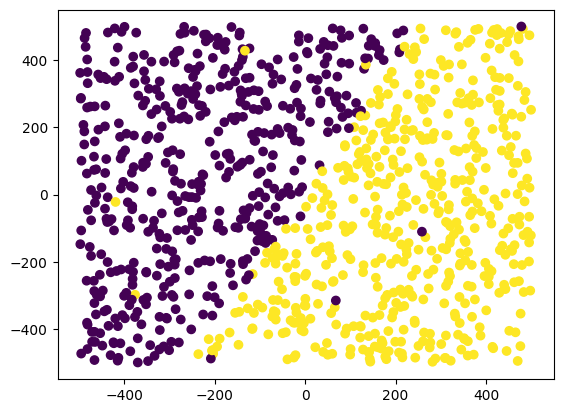

In [1]:
from networkx.algorithms.bipartite.basic import color
# Generate the source data

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

nsamples = 1000    # number of samples in data set
noiselevel = .01  # chance that a data point gets assigned with a reversed class than dictated by the model

x = np.random.rand(nsamples) * 1000 - 500
y = np.random.rand(nsamples) * 1000 - 500

Group = np.ones(nsamples)
y_actual = [] # calculate y_actual so we already have it 
for i in range(nsamples):
    value = 4*x[i]-2*y[i]+.8      
    if value < 0:
        Group[i] = 1
        y_actual.append(0)
    else:
        Group[i] = 2
        y_actual.append(1)

# noisify the data
for i in range(nsamples):
    if np.random.rand() <= noiselevel:
        if Group[i] == 1:
            Group[i] = 2
            y_actual[i] = 1 
        else:
            Group[i] = 1
            y_actual[i] = 0

Data = np.column_stack((x,y))

# this makes the result worst - left it out for personal reference
# standardize X ( remove spikes that adds no value )
#scaler = StandardScaler()
#Data = scaler.fit_transform(Data)

# let's plot it to get a visual impression
plt.scatter(x,y,c=Group)

### Task 1: Coding a Perceptron: going forward

#### Introduction
A Perceptron is an ANN with a single node. It uses $n$ input features, $n$ weights, a $bias$ term and an activation function to compute an output. The sum of the *x_i* input features multiplied by their respective *w_i* weights is then added to a $bias$ term before being passed to an activation function which gives us our final $output$:

$$output=ActivationF(bias+\sum\limits_{i=1}^{n}{x_i*w_i})$$



![Perceptron](perceptron.png)

Looking at our classification problem:
 * we have two input features: $x$ and $y$
 * we have one output feature: $Group$
 
Since our target output feature is discrete and binary (only two possible values), we want an activation function that will turn whichever continuous value is passed to it into something we can interpret as a probability of being in the first or second group. For this exercise, we will use the sigmoid function, which will provide us with a value between 0 and 1, and interpret this $output$ value as the probability that the input features belong to a data point for which $Group=2$. Since this is a binary classification problem, the probability that the input features belong to a data point for which $Group=1$ is $1-output$.

The sigmoid function is defined like this:
$$SigmoidF(x)=\frac{1}{1+e^{-x}}$$

In order to calculate $e^{-x}$, we can use the numpy *np.exp()* function.

So Which means our perceptron looks like this:

![Perceptron with input features x and y](perceptron_xy.png)



#### Coding tasks
 1. Implement a perceptron as defined above:
     * It should be defined with a set of weights equal to the number of input features and have a bias term.
     * It should have a sum function.
     * When given input features (or better, numpy arrays of input features), an evaluation function should be able to calculate a final output (or numpy array of outputs) between 0 and 1, which we will later fit (in Task 2) to the probability that the input(s) are from Group 2.
     * The activation function doesn't have to be a modular part of the definition of the perceptron: it can simply be hard coded as part of the evaluation function if you want, we are not writing an ANN library!
 2. Write a group prediction function that takes your perceptron's output value and converts it to a more readable group prediction: it should return 1 if $output<.5$, return 2 if $output>.5$ and 0 if $output=.5$ (if it's a 50/50, it effectively has no idea).
 3. Initialise your perceptron with random weights and a random bias term, run the source data through it. Use your group prediction function to compare predicted vs actual and evaluate how accurate is it.
 4. Plot your model's group predictions in similar fashion to the plot shown in the data generation in order to get a visual impression of your model.

In [2]:
# calculate the sigmoid function as the activation function  
def activation_function(x):
    
    # values below -6 close to 0
    # values above  6 close to 1
    
    # clipp all the values to the range as all the values after that can be automatically converted to 0 or 1 without any calculations
    x = np.clip(x, -6, 6)
     
    # if values are < -6 or > 6 we set the result automatically
    # use the sign of the exponent to calculate the value using stable sigmoid function, by keeping the exponent low
    # and looking at the sign of the input value (because we are clipping the second calculation doesn't add any value, but I wanted to give it a go )
    return np.where(x < -6, 0,
                    np.where(x > 6, 1,
                              np.where(x >= 0 ,  np.round(1 / (1 + np.exp(-x))), np.round(np.exp(x) / (1 + np.exp(x))))))

# run the predictor function based on the input we predict the group it belongs to 
def group_predictor(outputs) :
    # group 1 value 1 
    # group 2 value 2
    return [
        1 if output < 0.5 else 2 if output > 0.5 else 0
        for output in outputs
    ]

# calculate the sum 
def sum_function(X, weights, bias) :
    if not isinstance(X, np.ndarray):
         raise ValueError('Parameter X is supposed to be of type np.array.')
        
    # dot will throw an exception if the shapes of weights + bias not the same
    return np.dot(X, weights) + bias
                         
# run the activation function on the output from the sum function  
def evaluate_function(X, weights, bias):
    return activation_function(sum_function(X, weights, bias))

# calculate the accuracy of the predictions vs actual 
# let the sum method do all the work, but we are trying to sum all the times the value is the same in the two lists 
def calculate_accuracy(y_actual, y_predictions):
    if not isinstance(y_actual, np.ndarray) or not isinstance(y_predictions, np.ndarray):
         raise ValueError('The method is supposed to be used with np.array lists only.')
        
    return (np.sum(y_actual == y_predictions) / len(y_actual)) * 100

In [8]:
#Data  - X [sample input]
#Group - y [sample label]

# I picked the strategy because it goes great with sigmoid , since we input 1000 points * 2 and get out 1000
xavier_initializer_weights = 2 / (len(Data) * 2 + len(Data))

#pick values between - and + opens up the range , we don't want to be bias
weights = np.random.uniform(-1 * xavier_initializer_weights, xavier_initializer_weights, 2) # number of features 2
print(weights)

# pick the bias value to be between 0 and 0.1, bias by nature are small numbers
# why generate large numbers ( I still see a jump between runs from low accurate rate to height rate )
bias = round(np.random.uniform(0, 0.1), 3)
print(bias)

output = evaluate_function(Data, weights, bias)
predictions = group_predictor(output)

print(f"How accurate is it: {calculate_accuracy(np.array(Group), np.array(predictions)):.2f} %")

[0.00061368 0.00013964]
0.001
How accurate is it: 82.90 %


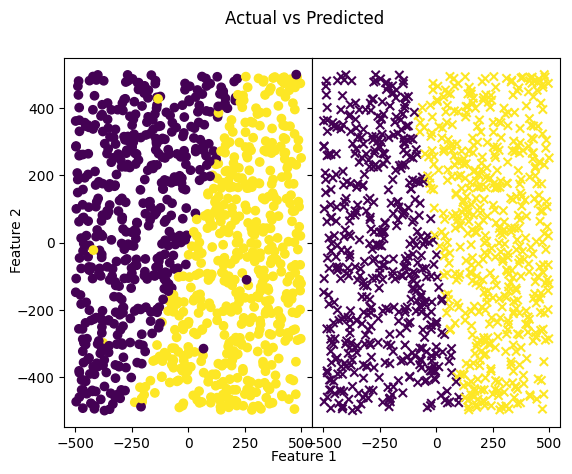

In [10]:
# Initialise the subplot function using number of rows and columns (as we want two graphs one next to each other)
# share the x and y axis - no need to kill the graph with useless info

fig = plt.figure()

# create a 1 row by 2 columns space for the two graphs 
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
(actualGraph, actualPredicted) = gs.subplots(sharex='col', sharey='row')

#share the header for the two graphs  
fig.suptitle('Actual vs Predicted')
    
# add the actual labels vs predicted labels    
actualGraph.scatter(Data[:, 0],Data[:, 1],c=Group, marker='o', cmap='viridis')
actualPredicted.scatter(Data[:, 0],Data[:, 1],c=predictions, marker='x')

# set the labels on the outside to share 
fig.text(0.5, 0.04, 'Feature 1', ha='center')
fig.text(0.04, 0.5, 'Feature 2', va='center', rotation='vertical')

plt.show()  

### Task 2: Coding a Perceptron: gradient descent

#### Introduction
Like for our polynomial model in the previous E-tivity, we will use gradient descent to update our weights and bias over a number iterations and slowly improve our model.

In order to implement a gradient descent, we will need a number of things:
 * a loss function
 * a way to calculate gradients for our weights/bias
 * a weights/bias update strategy

**Loss function:** rather than looking at the final class prediction, we will be looking at the model's output after the activation function. Since we defined that $[0,1]$ interval value as the probability that the input features correspond to Group 2, we want that value to be as close to $1$ as possible for Group 2 data points, and as close to $0$ as possible for Group 1 data points. Defining individual error as:

$$output_{actual}-output_{predicted}$$

We will keep things simple by simply defining our loss as the sum of squared errors, so for a training set of $n$ samples:

$$Loss=\sum\limits_{i=1}^{n}{{(output_{i_{actual}}-output_{i_{predicted}})}^2}$$

**Gradient calculation:** rather than using calculus, we will numerically evaluate our gradients. For a given weight $w$ and a small enough $\epsilon$ value, if we adjust $w$ by plus or minus $\epsilon$ and calculate the loss in both cases, we can compute the gradient like this:

$$gradient_w=\frac{Loss_{w+\epsilon}-Loss_{w-\epsilon}}{2\epsilon}$$

It's not terribly efficient to calculate our loss that many times with a slightly different model, but in this simple case it'll do just fine and will spare us the calculation of partial derivatives. As a side thought that is **not** part of the E-tivity: can you understand why/how this calculation works?

**Weight/bias update strategy:** as in our polynomial regression model, we will define a learning rate $lr$ and update each weight/bias in our perceptron using the following formula:
$$w_{new}=w_{current}-lr\times gradient_w$$

#### Coding tasks
 1. Implement a loss function using the sum of squared errors defined above.
 2. Implement a model update function that will calculate gradients for your perceptron's weights/bias and return you a new set of weights/bias that reduces loss. You can try starting with $lr=0.01$ and $\epsilon=0.01$.
 3. Verify that the new model has indeed reduced loss.
 4. Proceed to fit your model until you're happy with it. Do so by repeating the model update over a number of iterations until it hits your choice of stop condition.
 5. Evaluate your final model's accuracy and plot its predictions.

In [5]:
# calculate the loss function of actual vs predicted
def loss(y_actual, y_predicted):
    if len(y_actual) != len(y_predicted) :
        raise ValueError('The size of y_actual and y_predicted must match') 
      
    return np.sum(np.square(y_actual - y_predicted))

# calculate the gradient for all weights 
def gradients_weight(X, y_actual, weights, bias, epsilon):
    
    gradients = []
    
    # loop all the weights and adjust 1 weight at a time , then reset it back to what it was and 
    #adjust the second weight
    for index in range(len(weights)):
    
        current_weight = weights[index]
    
        # calculate plus error value
        weights[index] += epsilon # move to the right by 1 
        y_predict_plus_error = loss(y_actual, evaluate_function(X, weights, bias))
        
        # calculate minus error value 
        weights[index] -= 2 * epsilon # move to the left by 2 (don't forget we moved to the right by 1 first)
        y_predict_minus_error = loss(y_actual, evaluate_function(X, weights, bias))
        
        # calculate gradient , if the value of the gradient is zero we have reached the minimum
        # we still record the zero value
        # slope of the tangent line between the two points
        gradient = (y_predict_plus_error - y_predict_minus_error) / 2 * epsilon
        
        # store gradient 
        gradients.append(gradient)
        
        # reset the weight value to before the calculation 
        weights[index] = current_weight
    
    return gradients

def gradient_bias(X, y_actual, weights, bias, epsilon) :

    # same story as with gradient weights we + / - epsilon , to calculate the new value
    bias_minus = bias - epsilon
    bias_minus_error = loss(y_actual, evaluate_function(X, weights, bias_minus))
                
    bias_plus = bias + epsilon
    bias_plus_error = loss(y_actual, evaluate_function(X, weights, bias_plus))

    return bias_plus_error - bias_minus_error / 2 * epsilon

# calculate new weights given the gradient for all the weights 
def calculate_new_weight(weights, gradient_weights, lr):
    
    if len(weights) != len(gradient_weights) :
        raise ValueError('The size of weights and gradients must match')
    
    # loop the list of weights and calculate the new value using the gradient 
    for index_weight, weight_item in enumerate(weights): 
        weights[index_weight] = weight_item - (lr * gradient_weights[index_weight])
        
    return weights

# calculate new bias given the gradient 
def calculate_new_bias(bias, gradient_bias, lr):
    
    return bias - (lr * gradient_bias)

def get_gradient_calculate_new_values(X, y_actual, weights, bias, epsilon, lr):    
    # calculate gradient weights
    weight_gradients = gradients_weight(X, y_actual, weights, bias, epsilon)
    weights_new = calculate_new_weight(weights, weight_gradients, lr)
    
    # calculate gradient bias and new value 
    bias_gradients = gradient_bias(X, y_actual, weights, bias, epsilon)
    bias_new = calculate_new_bias(bias, bias_gradients, lr)

    return weights_new, bias_new, weight_gradients, bias_gradients

In [11]:
#Data  - X [sample input]
#Group - y [sample label]
#weights = np.random.rand(2) # number of features
#bias = np.random.rand()
#y_actual = gets calculated as part of Group calculation 

epsilon = 0.01
lr = 0.01

print(f"Data: {Data[0: 3]}... \n y_actual {y_actual[:3]}...  \n weights {weights} \n bias {bias}")

Data: [[-247.70453799  349.57148553]
 [ 219.16715247 -330.55648891]
 [ 414.09225945  195.21410657]]... 
 y_actual [0, 1, 1]...  
 weights [0.00061368 0.00013964] 
 bias 0.001


In [12]:
best_accuracy = 0
exit_threshold = 1e-2 # exit threshold- faster convergence
previous_loss = float('inf')

weights_actual = weights
bias_actual = bias

loss_values = []
accuracy_values = {}
weight_gradients_values = []

# calculate initial loss value 
initial_loss = loss(y_actual, evaluate_function(Data, weights_actual, bias_actual))
loss_values.append(initial_loss)
print(f"Initial loss value: {initial_loss}")

for epoch in range(100):

    weights_new, bias_new, weight_gradients, bias_gradients = get_gradient_calculate_new_values(Data, y_actual, weights_actual, bias_actual, epsilon, lr)

    # if weight gradient is zero we are at the min, could be a local, I have noticed a jump in the values when the gradient is zero for
    # the calculation of the new weight (Tried to skip the update when the gradient is zero, but saw no benefit to left it as it is)
    weights_actual = weights_new
    bias_actual = bias_new
              
    y_predicted_training = evaluate_function(Data, weights_actual, bias_actual) 
    current_loss = loss(y_actual, y_predicted_training)
        
    # keep track of all the gradients  / losses 
    weight_gradients_values.append(weight_gradients)
    loss_values.append(current_loss)
        
    # calculate accuracy  of y_actual - y_predicted 
    accuracy = calculate_accuracy(np.array(y_actual), np.array(y_predicted_training))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        accuracy_values[best_accuracy] = [weights_actual, bias_actual, current_loss, epoch]

    # exit once below the threshold   
    if abs(previous_loss - current_loss) < exit_threshold:
        break
            
    previous_loss = current_loss

Initial loss value: 171.0


In [13]:
# get beast values stats 
print(f"Best accurate: {best_accuracy:.2f} %")
print(f"Best weight: {accuracy_values[best_accuracy][0]}")
print(f"Best bias: {accuracy_values[best_accuracy][1]}")
print(f"Best loss value: {accuracy_values[best_accuracy][2]}")
print(f"Best value at index: {accuracy_values[best_accuracy][3]}")

Best accurate: 96.10 %
Best weight: [ 0.11231368 -0.02471036]
Best bias: -0.9442500000000001
Best loss value: 39.0
Best value at index: 1


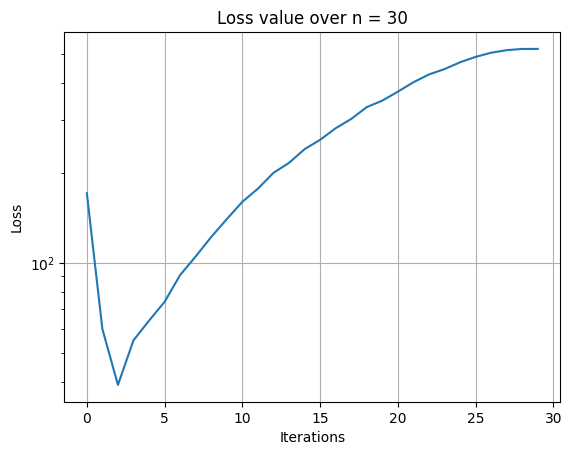

In [14]:
plt.figure()
plt.semilogy(range(len(loss_values)), loss_values)

plt.title(f'Loss value over n = {len(loss_values)}')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [ ]:
# ------------- personal ref --------------------
#print(loss_values.pop())

# Create a meshgrid for plotting the loss function in 3D
#x = np.array([item[0] for item in weight_gradients_values])
#y = np.array([item[1] for item in weight_gradients_values])
#X, Y = np.meshgrid(x, y)
#Z = np.array([loss_values for _ in range(len(loss_values))])

# Plot the loss function in 3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X, Y, Z, cmap='viridis')

#ax.set_xlabel('Iterations')
#ax.set_ylabel('Loss')
#ax.set_zlabel('Loss Value')
#ax.set_title('3D Plot of Loss Function')

#plt.show()

### Task 3: Scikit-learn

#### Introduction
Scikit-learn is a handy machine learning module for Python. It comes with plenty of functions to fit various types of models, as well as with general convenience tools such as splitting multi-featured data into training/testing partitions.

In the context of this E-tivity, we will be taking advantage of two things:
 * *sklearn.neural_network.MLPClassifier*: a class used to generate ANNs. MLP stands for Multi-layer Perceptron, which means that we will have to define at least one hidden layer of neurons in our network.
 * *sklearn.model_selection.train_test_split*: a function used to split data into training/testing partitions.

Documentation for these two can be found respectively at:
 * http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
 * http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Alternatively, type *MLPClassifier??* or *train_test_split??* in a code cell and run the cell to get the source code for these functions, which, conveniently, also contains some documentation.

**About train_test_split:** note that we will use the traditional notation that calls the array of input features $X$ and the array of actual outputs $Y$. These $X$ and $Y$ represent our inputs/outputs, and are not the same as the $x$ and $y$ arrays we defined originally. In fact we will define $X$ as a two dimensional array constructed from $x$ and $y$, while $Y$ will simply take the value of the $Group$ array.

**About hidden layers:** hidden layers are additional layers of nodes used in the calculation of the output. Each node is connected to a number of inputs which it will multiply by respective weights, add to a bias, and pass through an activation function. That output goes forward in the network, either to the final output node, or to another hidden layer. See the drawing below for an illustration of an ANN with two hidden layers of respective sizes 4 and 3. That's a lot more parameters to optimise than our simple perceptron, but it allows the model to fit much more complex relationships between the input features.

![ANN with 2 hidden layers](ann_2layers.png)

#### Coding tasks
The code below imports the required modules and defines the input data in the required shape. Complete it with additional code doing the following:
 1. Split X and Y into training and testing partitions, with 20% of the data for testing.
 2. Define a multi-layer perceptron with one hidden layer containing 2 nodes, a logistic sigmoid activation function, a stochastic gradient descent solver, a starting learning rate of 0.0001 and a batch size of 1.
 3. Fit the model to your *training* data
 4. Print out the mean accuracy of your model on the *testing* data.
 5. Plot the model's predictions on the *testing* data.

Best parameters: {'activation': 'logistic', 'batch_size': 1, 'hidden_layer_sizes': 2, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'solver': 'sgd'}
Best cross-validation score: 0.99
Accuracy: 0.99


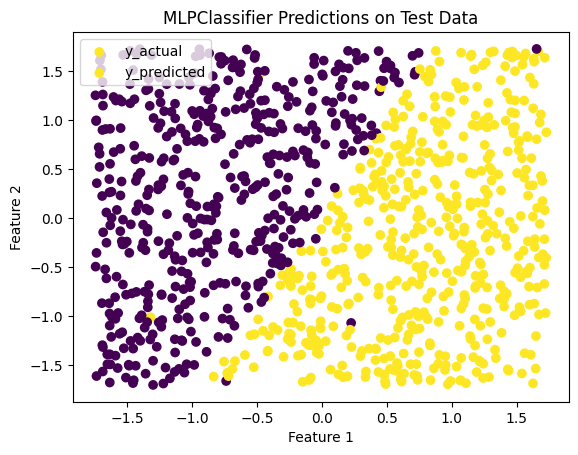

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# we define our input features as a single multi-dimensional array by 'stacking' them into columns
X = np.column_stack((x,y))

# we also define our output feature, simply for the sake of convenience
Y = Group

# split data into 80% training and 20% testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

param_grid = {
    'hidden_layer_sizes': [2],
    'activation': ['logistic'],
    'solver': ['adam', 'sgd'], # adam is an improvement on sgd 
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'batch_size' : [1]
}

# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# define a new MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=10000)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# fit the classifier to the training data
grid_search.fit(X_train, Y_train)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.2f}')

# print out mean accuracy of that trained model on the testing data
best_mlp = grid_search.best_estimator_
accuracy = best_mlp.score(X_test, Y_test)
print(f'Accuracy: {accuracy:.2f}')

# plot the model's predictions on the testing data
Y_pred = best_mlp.predict(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, marker='o', label='y_actual')
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_pred,  label='y_predicted')

# Adding labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('MLPClassifier Predictions on Test Data')
plt.legend()
plt.show()

### Task 4: Model fitting challenge

**Important:** Note that your work on this task should **not** be posted publicly. This is an extra task that should only be submitted to Brightspace.

#### Introduction: feature engineering
In this final task, you will be given a data set and will have to try and fit it with an ANN. The challenge will come from the fact that while you will get data similar to what we used previously: two features $x$ and $y$, and a target output $group$, the value of $group$ has been calculated in a way that the ANN will not be naturally able to fit. This means that you will have to expand on the starting two features, through *feature engineering*.

Consider the data below:

In [ ]:
feateng_nsamples = 1000

feateng_x = np.random.rand(feateng_nsamples) * 20 - 10
feateng_y = np.random.rand(feateng_nsamples) * 20 - 10

feateng_group = np.ones(feateng_nsamples)

for i in range(feateng_nsamples):
    if ( 0.6*np.cos(feateng_x[i]) - 0.4*np.cos(feateng_y[i]) - .3 < 0):
        feateng_group[i] = 1
    else:
        feateng_group[i] = 2
        
feateng_data = np.column_stack((feateng_x, feateng_y, feateng_group))
plt.scatter(feateng_x, feateng_y, c=feateng_group)

The group of each observation (1 or 2, mapped to yellow and blue) is a direct function of the input features $x$ and $y$. But were we to try and train an ANN to fit the data, it'd have trouble fitting it well. A complex enough model with multiple hidden layers might be able to fit, but it probably wouldn't work out well for data generated in the same way but outside of the $[-10,10]$ interval used in training. This is because the data is based on $cos(x)$ and $cos(y)$, which can't easily be modelled through weighted sums of $x$ and $y$.

In order to find the best possible model, we would need to engineer two new features from the existing ones: from $x$ and $y$, we will generate $cos(x)$ and $cos(y)$:

In [ ]:
feateng_cosx = np.cos(feateng_x)
feateng_cosy = np.cos(feateng_y)
feateng_data = np.column_stack((feateng_x, feateng_y, feateng_cosx, feateng_cosy, feateng_group))

If we use these 4 features to try and $group$, the ANN will have a far easier time. Instead of trying to predict $group$ simply from weighted sums of $x$ and $y$, the ANN will try to predict $group$ from weighted sums of $x$, $cos(x)$, $y$ and $cos(y)$. And it should quickly find that the best fit only uses $cos(x)$ and $cos(y)$, and converge until it finds the combination of weights and bias that work best. While this is **not** part of thie E-tivity, feel free to experiment on the side and try to fit an ANN to the data above, first only with $x$ and $y$, then with the enriched data. The latter should perform far better.

Of course, when trying to fit some data, you will rarely know in advance what specific features will lead to a better fit. So there is an exercise in trying to think of what the shape of the data might come from, as well as some trial and error generating additional features and trying to fit models. But the common thread of engineered features is that the ones likely to provide considerable improvements are the features that can't trivially be calculated from a weighted sum. There would be no point to create a feature for $2\times x$ and $3\times x$ for example, as the ANN will naturally try various weights to multiply $x$ by.

#### Introduction: the mystery data

In addition to this notebook, you should have been provided with the "t4_data.csv" CSV file. The code below will load that file as a numpy array and plot it. The data contains three columns: two features, and a target class. For plotting purposes we plot the first feature as $x$, the second feature as $y$, and colour the dots according to class.

In [ ]:
mydata = np.genfromtxt('t4_data.csv', delimiter=',')
plt.scatter(mydata[:,0], mydata[:,1], c=mydata[:,2])

#### Coding task
Your job is to use the sklearn MLPClassifier and train a model that can predict the class as accurately as possible.
 * You can play with the various options available in MLPClassifier (hidden layers, solver...).
 * It is recommended that you split your data into training/testing to avoid the risk of designing an overly complex model that overfits.
 * You only have two initial features, let's call them $x$ and $y$. These are unlikely to easily generate a good fitting model due to how the data was generated in the first place. You will need to either design a complex model, or do some clever feature engineering and create extra features out of these two. Think of what values based on $x$, $y$ or both wouldn't be naturally represented through a weighted sum, enrich your source data with these extra columns, and see if you can improve your classification.
 * Print out your final accuracy on training/testing data and plot your model's predictions also both on training/testing data.
 * Target is >95% accuracy over both sets, and in order to get the max grade of 20, you'll need to reach this with a single hidden layer.

## Reflection

